In [61]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import warnings
warnings.filterwarnings('ignore')


In [62]:
merged_df = pd.read_csv('data/preprocessed_data.csv', index_col=0, usecols=[0,1,9,10,13])

In [63]:
merged_df

,ENG_FUEL_RATE,RT_EXH_TEMP,RT-LT_EXH_TEMP,TURBO_OUTLET_PRESSURE
SS_TimeStamp,,,,
2014-06-13 17:02:00,337.35,551,4,288
2014-06-13 17:02:00,337.05,549,4,288
2014-06-13 17:02:00,339.35,547,2,288
2014-06-14 11:00:00,321.40,557,7,282
2014-06-14 11:01:00,335.60,569,10,300
...,...,...,...,...
2018-10-07 05:50:00,299.00,548,-5,260
2018-10-07 05:50:00,323.85,536,-4,286
2018-10-07 05:50:00,297.05,585,0,274


In [64]:
# Define the proportion for the test size
test_size = 0.2

In [65]:
# Compute the number of rows in the test set
n = merged_df.shape[0]
test_set_size = int(n * test_size)

In [66]:
# Define train and test sets
train_df = merged_df[:n - test_set_size]
test_df = merged_df[n - test_set_size:]

In [67]:
# Shape of both the datasets
train_df.shape, test_df.shape

((79528, 4), (19881, 4))

In [68]:
# Calculate Z-scores 
z_scores = zscore(train_df)

# Define a threshold
threshold = 3

# Identify outliers
outliers = np.abs(z_scores) > threshold

# Replace outliers with np.nan
df_nan = train_df.copy()
df_nan.values[outliers] = np.nan

In [69]:
train_df = df_nan.copy()
train_df[df_nan.isnull()] = df_nan.rolling(window=5, min_periods=1).mean()[df_nan.isnull()]

In [70]:
# normalize both the datasets
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_parameters=scaler.fit(train_df)
X_train = scaled_parameters.transform(train_df)
X_test = scaled_parameters.transform(test_df)

In [71]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (79528, 1, 4)
Test data shape: (19881, 1, 4)


In [72]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='linear', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = Dropout(0.2)(L1)
    L3 = LSTM(4, activation='sigmoid', return_sequences=False)(L1)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='sigmoid', return_sequences=True)(L4)
    L6 = Dropout(0.2)(L5)
    L7 = LSTM(16, activation='linear', return_sequences=True)(L5)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [73]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 16)             1344      
                                                                 
 lstm_9 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_11 (LSTM)              (None, 1, 16)             1344      
                                                           

In [74]:
# fit the model to the data
nb_epochs = 10
batch_size = 14
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.02).history

Epoch 1/10
5567/5567 [==============================] - 25s 4ms/step - loss: 0.0346 - accuracy: 0.8008 - val_loss: 0.0068 - val_accuracy: 0.9340
Epoch 2/10
5567/5567 [==============================] - 19s 3ms/step - loss: 0.0077 - accuracy: 0.8563 - val_loss: 0.0053 - val_accuracy: 0.9189
Epoch 3/10
5567/5567 [==============================] - 17s 3ms/step - loss: 0.0074 - accuracy: 0.8543 - val_loss: 0.0047 - val_accuracy: 0.9239
Epoch 4/10
5567/5567 [==============================] - 19s 3ms/step - loss: 0.0073 - accuracy: 0.8540 - val_loss: 0.0057 - val_accuracy: 0.8347
Epoch 5/10
5567/5567 [==============================] - 19s 3ms/step - loss: 0.0038 - accuracy: 0.9341 - val_loss: 0.0011 - val_accuracy: 0.9830
Epoch 6/10
5567/5567 [==============================] - 19s 3ms/step - loss: 0.0019 - accuracy: 0.9535 - val_loss: 0.0013 - val_accuracy: 0.9793
Epoch 7/10
5567/5567 [==============================] - 19s 3ms/step - loss: 0.0019 - accuracy: 0.9553 - val_loss: 0.0013 - val_ac

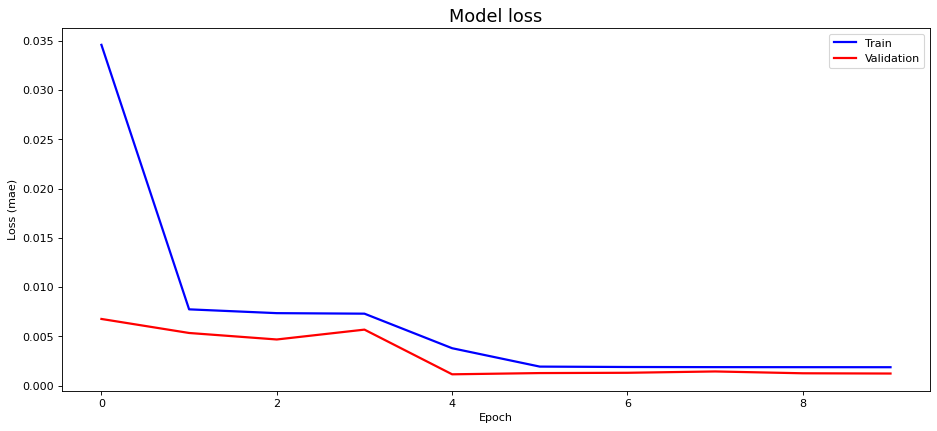

In [75]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [76]:
# Predictions using the model on the testing data and reshape the predictions so that inverse_transform could be performed on it
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

622/622 [==============================] - 1s 1ms/step


In [77]:
# Inverse_transform on the predicted values and the actual values
X_pred1 = scaler.inverse_transform(X_pred)
X_test = scaler.inverse_transform(X_test)

In [78]:
X_test.shape, X_pred1.shape

((19881, 4), (19881, 4))

In [79]:
# Residual i.e (Actual values - Predicted values)
resid=X_test[:]-X_pred1 [:]

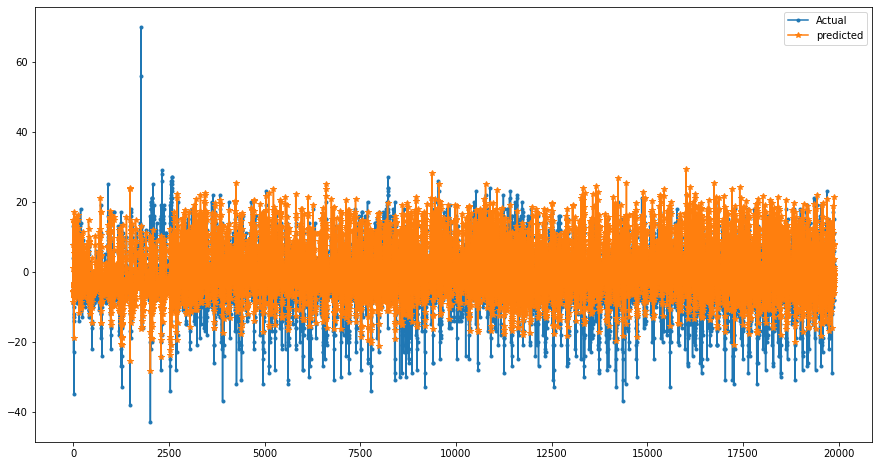

In [80]:
# Visualisation through line graph on one of the feature of data
# Actual values are in blue and Predicted values are in orange
plt.figure(figsize=[15,8])
plt.plot(X_test[:,2],label="Actual",marker=".")
plt.plot(X_pred1[:,2],label="predicted",marker="*")
plt.legend(loc="best")
plt.show()

# It can be clearly seen that the values are bounded with respect to the training data and thus resulting in accurate predictions.

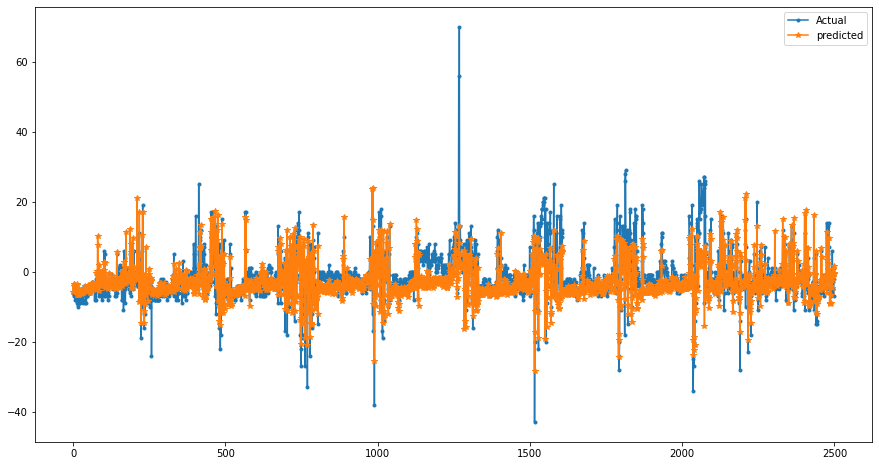

In [81]:
# A part of the whole data set for proper understanding
plt.figure(figsize=[15,8])
plt.plot(X_test[500:3000,2],label="Actual",marker=".")
plt.plot(X_pred1[500:3000,2],label="predicted",marker="*")
plt.legend(loc="best")
plt.show()